In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns
from pklshop.data import *

In [2]:
rally=get_tab_as_df('rally')

In [3]:
rally = rally[['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']]
rally['game_id'] = [int(x[1:]) for x in rally.game_id]
rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)

In [4]:
game=get_tab_as_df('game')[['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']]
game['game_id'] = [int(x[1:]) for x in game.game_id]
game['match_id'] = [int(x[1:]) for x in game.match_id]
game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
game = game.sort_values(['match_id','game_id']).reset_index(drop=True)

In [5]:
glist = list(rally.game_id.unique())
dlist = []
for i in range(len(glist)):
    gi = rally[rally.game_id==glist[i]].reset_index(drop=True)
    to_list = []
    to_game = glist[i]
    to_inds = list(gi.index[gi.to_team_id != 'N/A'])
    to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    skill_lvl = list(game.skill_lvl[game.game_id == glist[i]])[0]
    if (len(to_inds) > 0):
        for j in range(len(to_inds)):
            if j == 0:
                pre = list(range(to_inds[j]))
            else:
                pre = list(range(to_inds[j-1]+1,to_inds[j]))
            if j == len(to_inds)-1:
                post = list(range(to_inds[j]+1,len(gi)))
            else:
                post = list(range(to_inds[j]+1,to_inds[j+1]))
            toteam = to_teams[j]
            rallynbr = gi.rally_nbr.iloc[to_inds[j]]
            winpre = round(100*len(gi.iloc[pre][lambda x:x.w_team_id == toteam])/len(pre),1)
            winpost = round(100*len(gi.iloc[post][lambda x:x.w_team_id == toteam])/len(post),1)
            windelta = round(winpost-winpre,1)
            dlist.append([to_game,skill_lvl,j+1,toteam,rallynbr,winpre,winpost,windelta])

In [6]:
df_timeout = pd.DataFrame(dlist,columns=['game_id','skill_lvl','to_nbr','to_team','rally_nbr','prewin','postwin','deltawin'])

In [7]:
print('change in win percentage due to timeouts\n')
print(f'average: {round(df_timeout.deltawin.mean(),1)}')
print(f'median:  {df_timeout.deltawin.median()}')
print(f'maximum: {df_timeout.deltawin.max()}')
print(f'minimum: {df_timeout.deltawin.min()}')                                                      

change in win percentage due to timeouts

average: 7.3
median:  8.4
maximum: 60.0
minimum: -63.6


In [8]:
# df_timeout.sort_values('deltawin').to_csv('timeout_momentum_sorted.csv',index=False)

In [9]:
df_wteam = game[['w_team_id','game_id']].groupby('w_team_id').count().reset_index(drop=False)
df_lteam = game[['l_team_id','game_id']].groupby('l_team_id').count().reset_index(drop=False)
df_wteam.columns=['team_id','won']
df_lteam.columns=['team_id','lost']
df_wl=df_wteam.merge(df_lteam,on='team_id',how='left')
df_lw=df_lteam.merge(df_wteam,on='team_id',how='left')
df_wnl = df_wl[df_wl.lost.notnull()]
df_w=df_wl[df_wl.lost.isnull()]
df_l=df_lw[df_lw.won.isnull()]
df_allres = pd.concat([pd.concat([df_wnl,df_w]),df_l]).fillna(0)
df_allres['GP'] = df_allres['won']+df_allres['lost']
df_allres[['won','lost','GP']] = df_allres[['won','lost','GP']].astype(int)
df_allres['team_id'] = [int(x[1:]) for x in df_allres.team_id]
df_allres = df_allres.sort_values('team_id')
df_allres.team_id = 'T'+df_allres.team_id.astype(str)
df_tobyteam = df_timeout[['to_team','game_id']].groupby('to_team').count().reset_index(drop=False)
df_tobyteam.columns = ['team_id','TO']
df_teammetrx = df_allres.merge(df_tobyteam,on='team_id',how='left')
df_teammetrx.TO = df_teammetrx['TO'].fillna(0).astype(int)
df_teammetrx['TOsPerGame'] = (df_teammetrx.TO/df_teammetrx.GP).round(2)
df_teamcalc = df_timeout[['to_team','deltawin']].groupby('to_team').mean().round(1).reset_index(drop=False)
df_teamcalc.columns=['team_id','avgDeltaWin']
df_teammetrx = df_teammetrx.merge(df_teamcalc,on='team_id',how='left')
df_teammetrx=df_teammetrx[['team_id', 'GP', 'TO', 'TOsPerGame', 'avgDeltaWin']]
df_teammetrx = df_teammetrx.sort_values('avgDeltaWin',ascending=False).merge(get_tab_as_df('team')[['team_id','team_nm']],on='team_id',how='left').drop_duplicates()
# df_teammetrx.to_csv('team_timeout_data.csv',index=False)
print('team timeout data, sorted descending by average win % change:\n ')
df_teammetrx

team timeout data, sorted descending by average win % change:
 


,team_id,GP,TO,TOsPerGame,avgDeltaWin,team_nm
0,T9,2,1,0.50,60.0,Jesse Irvine & Anna Bright
2,T17,2,1,0.50,50.0,Ben Johns & Tyler Loong
4,T11,1,1,1.00,49.2,Chrissy Penfold & Eli Powell
6,T18,2,2,1.00,38.6,Collin Johns & AJ Koller
8,T16,1,1,1.00,36.7,Anna Bright & Jorja Johnson
10,T35,1,1,1.00,30.0,Jay Devilliers & Patrick Smith
12,T40,4,2,0.50,27.6,Ryan Kane & Brandon Ward
14,T13,4,2,0.50,26.1,Collin Johns & Ben Johns
16,T15,1,2,2.00,25.7,Vivienne David & Lauren Stratman
18,T41,1,1,1.00,23.5,David McNally & Daniel McNally


In [10]:
df_skill = game[['skill_lvl','game_id']].groupby('skill_lvl').count().round(1).reset_index(drop=False)
df_skill.columns=[['skill_lvl','num_games']]
df_skill['avg_delta_win'] = (df_timeout[['skill_lvl','deltawin']].groupby('skill_lvl').mean().round(1).reset_index(drop=False))['deltawin']
df_skill['pct_total'] = (100*df_skill.num_games/(df_skill.num_games.sum())).round(1)
df_skill[['skill_lvl','avg_delta_win','num_games','pct_total']].reset_index(drop=False)

,index,skill_lvl,avg_delta_win,num_games,pct_total
0,0,4.0,-12.5,1,2.0
1,1,4.5,-0.8,4,7.8
2,2,5.0,7.9,10,19.6
3,3,Pro,7.8,36,70.6


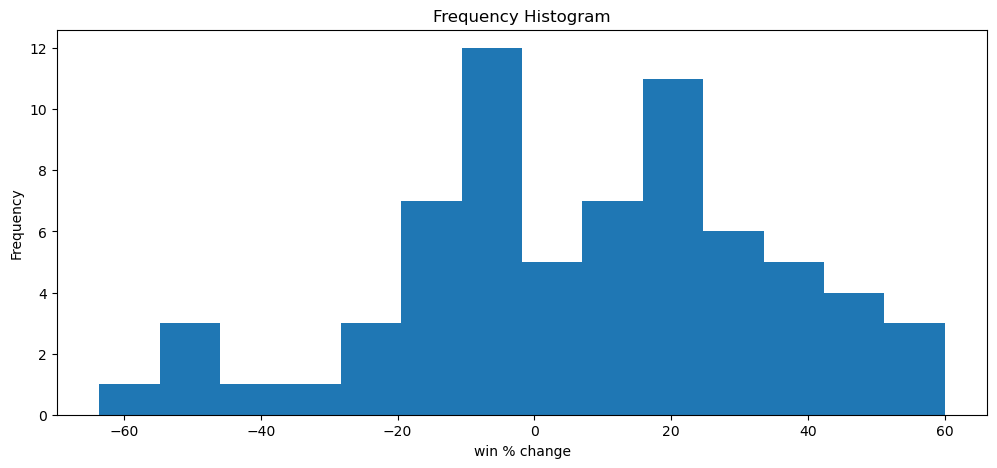

In [11]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawin, bins=14)
plt.gca().set(title='Frequency Histogram', xlabel = 'win % change', ylabel='Frequency');

## Group plots by skill level

In [12]:
df_pro=df_timeout[df_timeout.skill_lvl == 'Pro']
df_40=df_timeout[df_timeout.skill_lvl == '4.0']
df_45=df_timeout[df_timeout.skill_lvl == '4.5']
df_50=df_timeout[df_timeout.skill_lvl == '5.0']
skilldata=[list(x.deltawin) for x in [df_40,df_45,df_50,df_pro,df_timeout]]

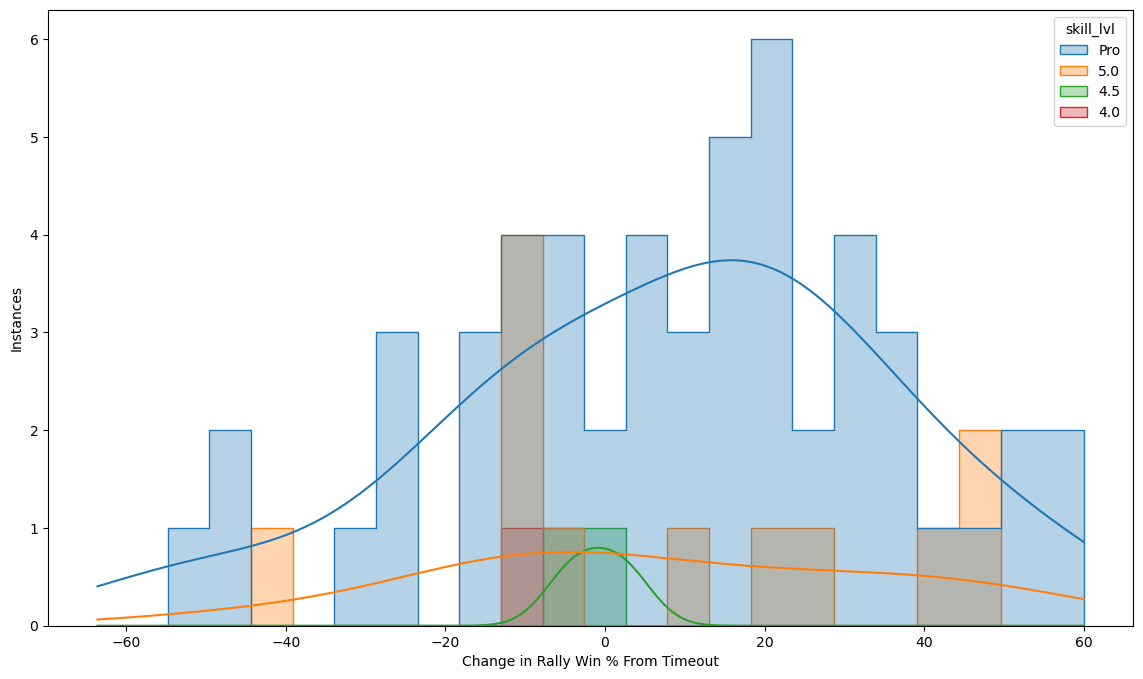

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-60, 60, 24)
p = sns.histplot(x="deltawin",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Rally Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

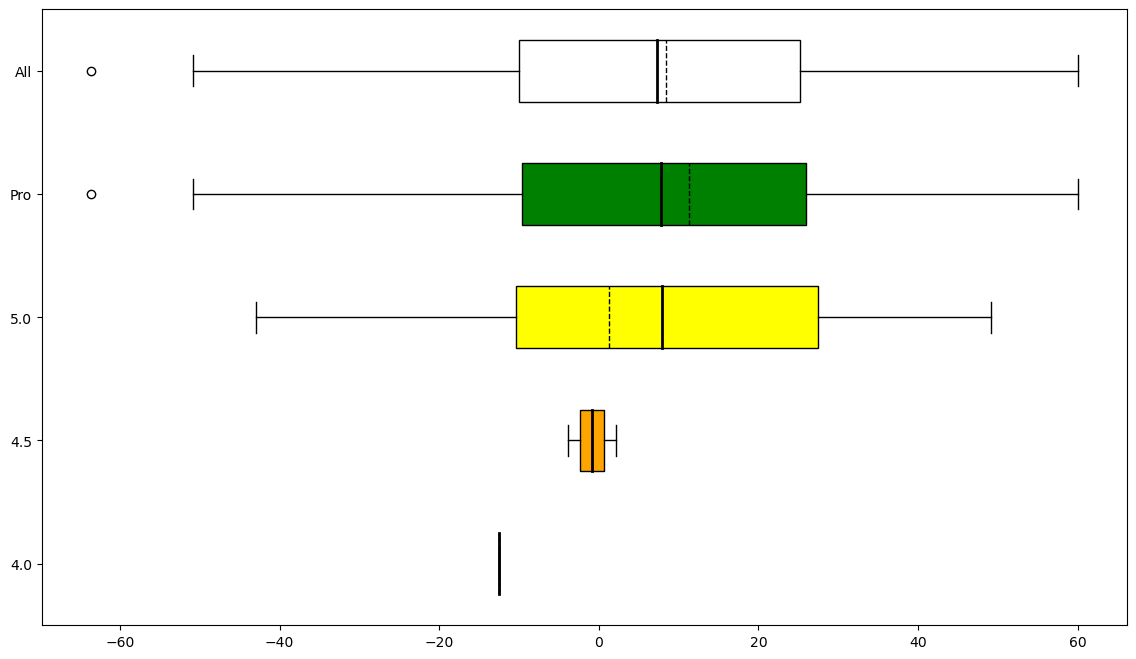

In [14]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')


box = plt.boxplot(skilldata,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['4.0','4.5','5.0','Pro','All'])

colors = ['red', 'orange', 'yellow', 'green', 'white']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

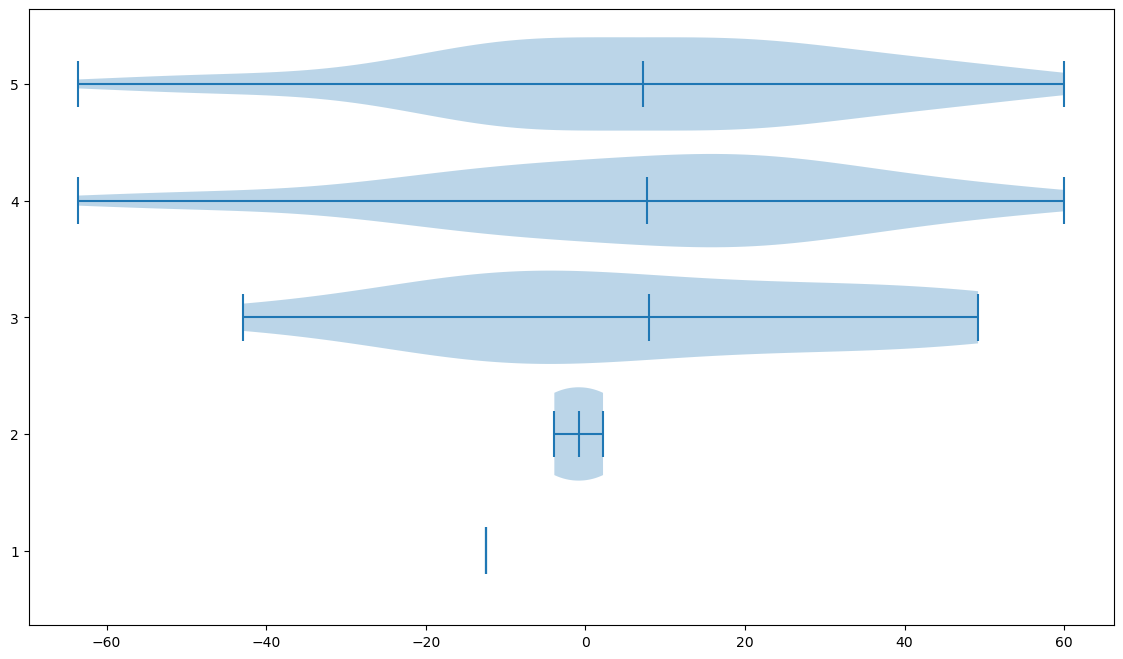

In [15]:
fig, ax = plt.subplots(figsize=(14, 8))
vio=plt.violinplot(skilldata,vert=0,showextrema=True,showmeans=True,widths=.8)
plt.show()

## Repeat plots - but distinguishing between only 2 skill levels:  "Pro" and "Amateur"

In [16]:
df_timeout_bypro = df_timeout
df_timeout_bypro.skill_lvl.iloc[df_timeout_bypro.skill_lvl != 'Pro'] = 'Amateur'
df_pro=df_timeout_bypro[df_timeout_bypro.skill_lvl == 'Pro']
df_amtr=df_timeout_bypro[df_timeout_bypro.skill_lvl == 'Amateur']
skilldata=[list(x.deltawin) for x in [df_amtr,df_pro,df_timeout_bypro]]

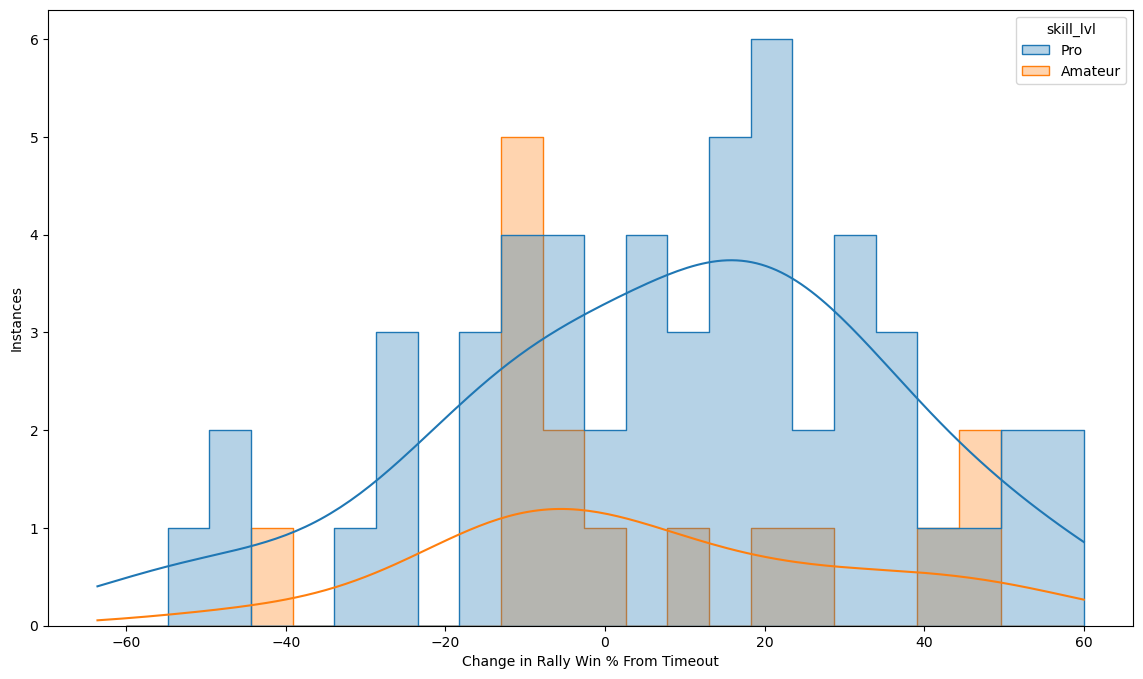

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-60, 60, 24)
p=sns.histplot(x="deltawin",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Rally Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

mean = solid line, median = dashed line


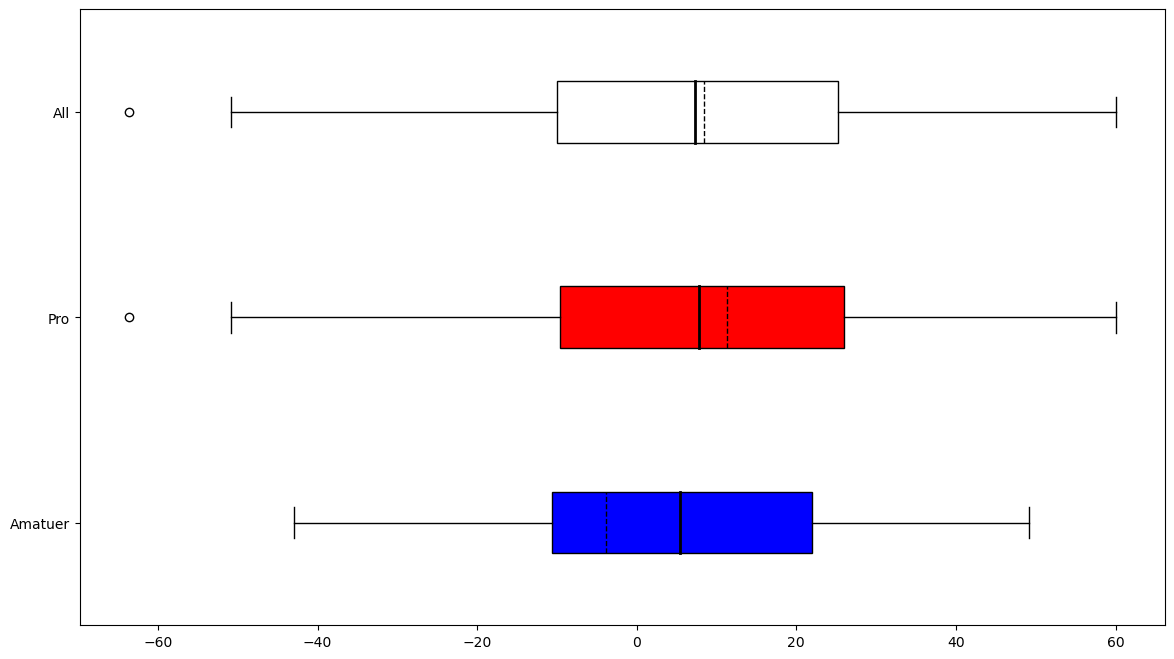

In [18]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')


box = plt.boxplot(skilldata,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['Amatuer','Pro','All'])

colors = ['blue', 'red', 'white']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
print('mean = solid line, median = dashed line')
plt.show()

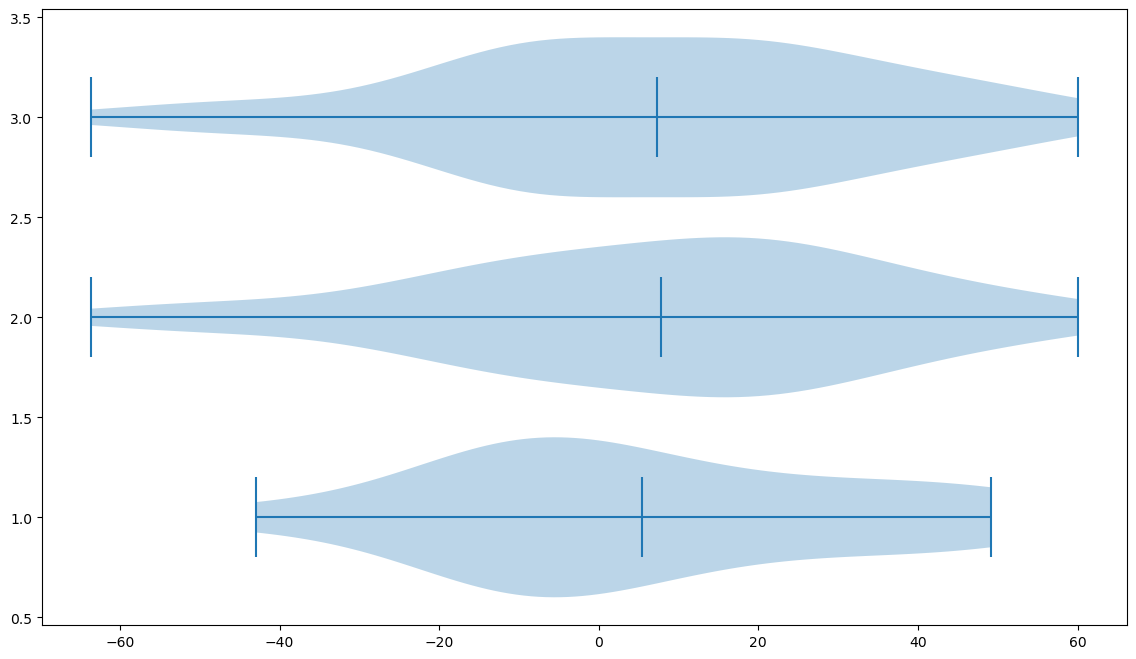

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))
vio=plt.violinplot(skilldata,vert=0,showextrema=True,showmeans=True,widths=.8)
plt.show()